In [ ]:
import sys
import torch
import gym
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:

hidden_size = 16
learning_rate = 0.015

GAMMA = 0.99
num_steps = 1000
max_episodes = 1500

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
class rb(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, learning_rate=0.01):
        super(rb, self).__init__()

        self.num_actions = num_actions
        self.critic_linear1 = nn.Linear(num_inputs, hidden_size)
        self.critic_linear2 = nn.Linear(hidden_size, 1)

        self.actor_linear1 = nn.Linear(num_inputs, hidden_size)
        self.actor_linear2 = nn.Linear(hidden_size, num_actions)

    def forward(self, state):
        state = Variable(torch.from_numpy(state).float().unsqueeze(0))
        value = F.relu(self.critic_linear1(state))
        value = self.critic_linear2(value)

        policy_dist = F.relu(self.actor_linear1(state))
        policy_dist = F.softmax(self.actor_linear2(policy_dist), dim=1)

        return value, policy_dist

In [ ]:
def reinforce_with_baseline(env):
    num_inputs = env.observation_space.shape[0]
    num_outputs = env.action_space.n

    reinforce = rb(num_inputs, num_outputs, hidden_size)
    ac_optimizer = optim.Adam(reinforce.parameters(), lr=learning_rate)

    all_lengths = []
    average_lengths = []
    all_rewards = []
    entropy_term = 0

    for episode in range(max_episodes):
        log_probs = []
        values = []
        rewards = []

        state = env.reset()
        for steps in range(num_steps):
            value, policy_dist = reinforce.forward(state)
            value = value.detach().numpy()[0,0]
            dist = policy_dist.detach().numpy()

            action = np.random.choice(num_outputs, p=np.squeeze(dist))
            log_prob = torch.log(policy_dist.squeeze(0)[action])
            entropy = -np.sum(np.mean(dist) * np.log(dist))
            new_state, reward, done, _ = env.step(action)

            rewards.append(reward)
            values.append(value)
            log_probs.append(log_prob)
            entropy_term += entropy
            state = new_state

            if done or steps == num_steps-1:
                Qval, _ = reinforce.forward(new_state)
                Qval = Qval.detach().numpy()[0,0]
                all_rewards.append(np.sum(rewards))
                all_lengths.append(steps)
                average_lengths.append(np.mean(all_lengths[-10:]))
                if episode % 50 == 0:
                    sys.stdout.write("episode: {}, reward: {}, total length: {}, average length: {} \n".format(episode, np.sum(rewards), steps, average_lengths[-1]))
                break

        # compute Q values
        Qvals = np.zeros_like(values)
        for t in reversed(range(len(rewards))):
            Qval = rewards[t] + GAMMA * Qval
            Qvals[t] = Qval

        #update actor critic
        values = torch.FloatTensor(values)
        Qvals = torch.FloatTensor(Qvals)
        log_probs = torch.stack(log_probs)

        advantage = Qvals - values
        actor_loss = (-log_probs * advantage).mean()
        critic_loss = 0.5 * advantage.pow(2).mean()
        ac_loss = actor_loss + critic_loss + 0.001 * entropy_term

        ac_optimizer.zero_grad()
        ac_loss.backward()
        ac_optimizer.step()

    return all_rewards




In [ ]:
env = gym.make('CartPole-v1')
np.random.seed(53)
seeds = np.random.randint(1000, size=5)
all_scores = []
for seed in seeds:
    print("started training with seed: ", seed)
    scores = reinforce_with_baseline(env)
    print("completed training with seed: ", seed)
    all_scores.append(scores)

In [ ]:
def moving_average(a, n) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

In [ ]:
smoothed_scores = [moving_average(s, 50) for s in all_scores]
smoothed_scores = np.array(smoothed_scores)
mean = smoothed_scores.mean(axis=0)
std = smoothed_scores.std(axis=0)

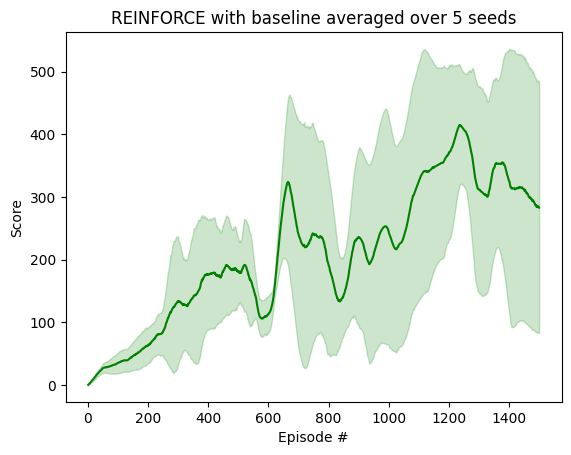

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
x = np.arange(1, len(mean)+1)
ax.plot(x, mean, '-', color='green')
ax.fill_between(x, mean - std, mean + std, color='green', alpha=0.2)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.title('REINFORCE with baseline averaged over 5 seeds')
plt.show()